In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
srcdir = "/fs/lustre/cita/hadden/03_comet_diffusion/01_MEGNO_grid/megno_grids/"

# Check width calculation

In [63]:
cmap = CometMap(5.15e-5,10,35/30)


In [64]:
def get_map_pts(pt0,Npts,m):
    pts=np.zeros((Npts,2))
    for i in range(Npts):
        pts[i]=pt0
        pt0=m(pt0)
    return pts

In [217]:
cmap.N = 5
cmap.m = 1e-5
cmap.q=45/30

/cita/h/home-2/hadden/Projects/01_celmech/celmech/celmech/miscellaneous.py:616: LinAlgWarning: Diagonal number 128 is exactly zero. Singular matrix.
  return lu_solve(lu_factor(A),y)
/cita/h/home-2/hadden/Projects/01_celmech/celmech/celmech/miscellaneous.py:731: UserWarning: Exceeded maximum number of quadruature points without converging.
N=256, delta = nan, target = 1.49e-08
  warnings.warn(msg)


In [219]:
def calcH(theta,w,cmap,J,K):
    w0 = cmap.N - (J-K)/K
    dw = w-w0
    H=0.5*dw*dw
    for k_minus_one,amp in enumerate(cmap.amps):
        k=k_minus_one+1
        if k%K==0:
            ck = amp/k
            H+= (0.5/np.pi) * cmap.eps * ck * np.cos(k * theta) 
    return H

In [220]:
cmap.N - (J-K) / K

0.0

In [264]:
cmap.N = 15

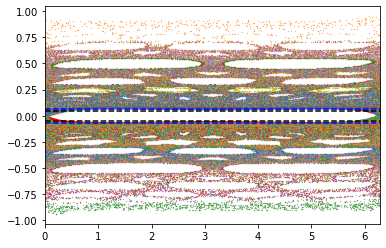

In [265]:
K = 1
J = K*cmap.N + 1
w0 = cmap.N - (J-K)/K
th_sx = 2*np.pi / K if K%2 else np.pi
wmin,wmax = w0 + 0.5 * np.array([-1,1])
theta,w = np.linspace(0,2*np.pi),np.linspace(wmin,wmax)
T,W = np.meshgrid(theta,w)

Energy = calcH(T,W,cmap,J,K)
Esx = calcH(th_sx,w0,cmap,J,K)

if K>1:
    CK = cmap.amps[K-1]/K
else:
    CK = cmap.amps[1]/2
Delta_w = 2 * np.sqrt(cmap.eps * CK / (2*np.pi))

psq=0
Dw_at_pi=0
for k_minus_1 in range(cmap.kmax):
    k = k_minus_1 + 1
    C = cmap.amps[k_minus_1] / k
    A = (0.5/np.pi) * cmap.eps * C
    psq += 2 * (A - A * np.cos(k*theta))
    Dw_at_pi += 4 * A if k%2 else 0
wsx = w0+np.sqrt(psq)
Dw_at_pi = np.sqrt(Dw_at_pi)

for w in np.linspace(wmin,wmax,100):
    pts = get_map_pts((0,w),1500,cmap)
    plt.plot(*np.transpose(pts),'.',ms=0.5)
plt.contour(T,W,Energy,levels=[Esx],linewidths=[3],colors='red')
plt.plot(theta,wsx)
plt.xlim(0,2*np.pi)
plt.axhline(w0+Delta_w,ls='--',color='k')
plt.axhline(w0-Delta_w,ls='--',color='k')
plt.axhline(w0+Dw_at_pi,ls='--',color='b')
plt.axhline(w0-Dw_at_pi,ls='--',color='b')

# Make theory curve

In [266]:
from celmech.maps import CometMap
from sympy import totient
def get_eps_crit(cmap):
    tot = 0
    first_order_half_width_sq = 0
    for k_minus_one,amp in enumerate(cmap.amps):
        k=k_minus_one+1
        ck = amp/k
        if k>1:
            half_width = np.sqrt(2 * ck / np.pi)
            tot+=2*totient(k)*half_width
        if k%2:
            # odd orders contribute to first-order 
            # width at pi
            first_order_half_width_sq += 4 * (0.5/np.pi) * ck
    tot += np.sqrt(first_order_half_width_sq)
    return 1/tot/tot

In [285]:
cmap._kmax = 32

qvals = np.linspace(40,65,10)
eps_crits = np.zeros(len(qvals))
reset = True
for q in qvals:
    for i,q in enumerate(qvals):
        if q>1.8*30 and reset:
            cmap._kmax = 12
            reset = False
        cmap.q = q/30
        eps_crit = get_eps_crit(cmap)
        eps_crits[i] = eps_crit

/cita/h/home-2/hadden/Projects/01_celmech/celmech/celmech/miscellaneous.py:616: LinAlgWarning: Diagonal number 128 is exactly zero. Singular matrix.
  return lu_solve(lu_factor(A),y)
/cita/h/home-2/hadden/Projects/01_celmech/celmech/celmech/miscellaneous.py:731: UserWarning: Exceeded maximum number of quadruature points without converging.
N=256, delta = nan, target = 1.49e-08
  warnings.warn(msg)


In [286]:
a_crit = (eps_crits / 5.15e-5/3)**(2/5)

# Read simulation results

In [287]:
all_tLy = []
all_megno = []
all_eject = []
for I in range(9):
    fi = srcdir+"result{}.npy".format(I)
    data = np.load(fi)
    all_megno.append(data[:,:,0])
    all_tLy.append(1/data[:,:,1])
    all_eject.append(data[:,:,2])

tLy = np.block([all_tLy[:3],all_tLy[3:6],all_tLy[6:]])
megno = np.block([all_megno[:3],all_megno[3:6],all_megno[6:]])
eject = np.block([all_eject[:3],all_eject[3:6],all_eject[6:]])

tLy[megno<3] = 1e9
tLy[eject==1.] = 1e3
vals = np.log10(tLy)

/tmp/ipykernel_3079779/1826884543.py:17: RuntimeWarning: invalid value encountered in log10
  vals = np.log10(tLy)


In [292]:
def qcrit_batygin(a,aN = 30,mN = 5.15e-5):
    log_arg = 24*24 * mN *(a/aN)**(5/2) / 5
    return aN * np.sqrt(np.log(log_arg))

In [307]:
pwd

'/cita/h/home-2/hadden/Projects/07_CometMap/notebooks'

/tmp/ipykernel_3079779/291657099.py:3: RuntimeWarning: invalid value encountered in sqrt
  return aN * np.sqrt(np.log(log_arg))


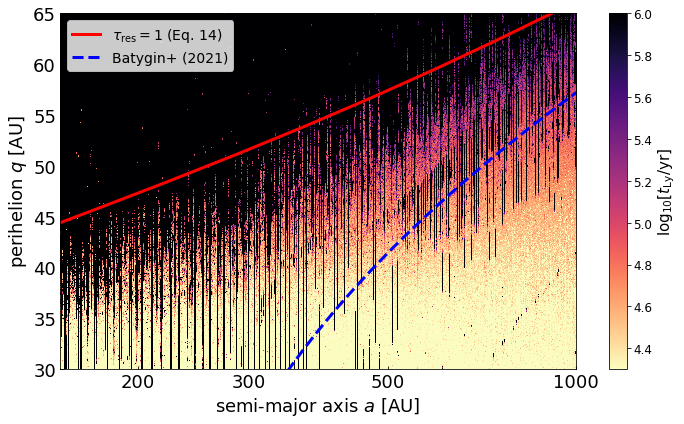

In [319]:
fig=plt.figure(figsize=(10,6))
plt.tick_params(direction='in',labelsize=18)
xticks = [200,300,500,1_000]
plt.xticks(np.log10(xticks),labels=["{}".format(x) for x in xticks])
ax = plt.gca()
im=plt.imshow(
    vals,
    interpolation="none",vmin=4.3,vmax=6,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(150),3,30,65]
)
cb = plt.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=12)
cb.set_label(r"$\log_{10}[t_\mathrm{Ly}/\mathrm{yr}]$",size=15)
plt.plot(np.log10(30*a_crit),qvals,color='r',lw=3,label=r"$\tau_\mathrm{res} = 1$ (Eq. 14)")
a = np.geomspace(150,1e3)
plt.plot(np.log10(a),qcrit_batygin(a),color='b',lw=3,ls='--',label=r"Batygin+ (2021)")
plt.xlim(np.log10(150),np.log10(1e3))
plt.ylim(30,65)
plt.legend(loc='upper left',fontsize=14)
plt.xlabel("semi-major axis $a$ [AU]",fontsize=18)
plt.ylabel("perihelion $q$ [AU]",fontsize=18)
plt.tight_layout()
plt.savefig("../figures/MEGNO_map.png")

In [312]:
np.log10(1000**(1.5) * 50)

6.198970004336019

In [314]:
np.log10(150**(1.5) * 50)

4.963106892919541

In [315]:
np.log10(150**(1.5) * 1)

3.264136888583522